In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.api.types import CategoricalDtype
import seaborn as sns
import folium
from folium import plugins
from folium.plugins import HeatMap
from urllib.request import urlopen
import json
import calendar
from calendar import month_abbr
%matplotlib inline
import calplot
import warnings
from scipy import stats
import sklearn.linear_model as lm

#turning off warnings
warnings.filterwarnings('ignore')

In [8]:
### Reading the source file

path = 'C:/Users/balda/Desktop/DTU/Social_data/311_noise_fixed.csv'

data = pd.read_csv(path).drop('Unnamed: 0', axis=1)

In [9]:
data['Created Date'] = pd.to_datetime(data['Created Date'])
data['Hour'] = data['Created Date'].dt.hour

In [10]:
category_list = ['Traffic noise','Social noise','Animal noise','Construction noise','Helicopter noise','Other']

# By year and hour of the day

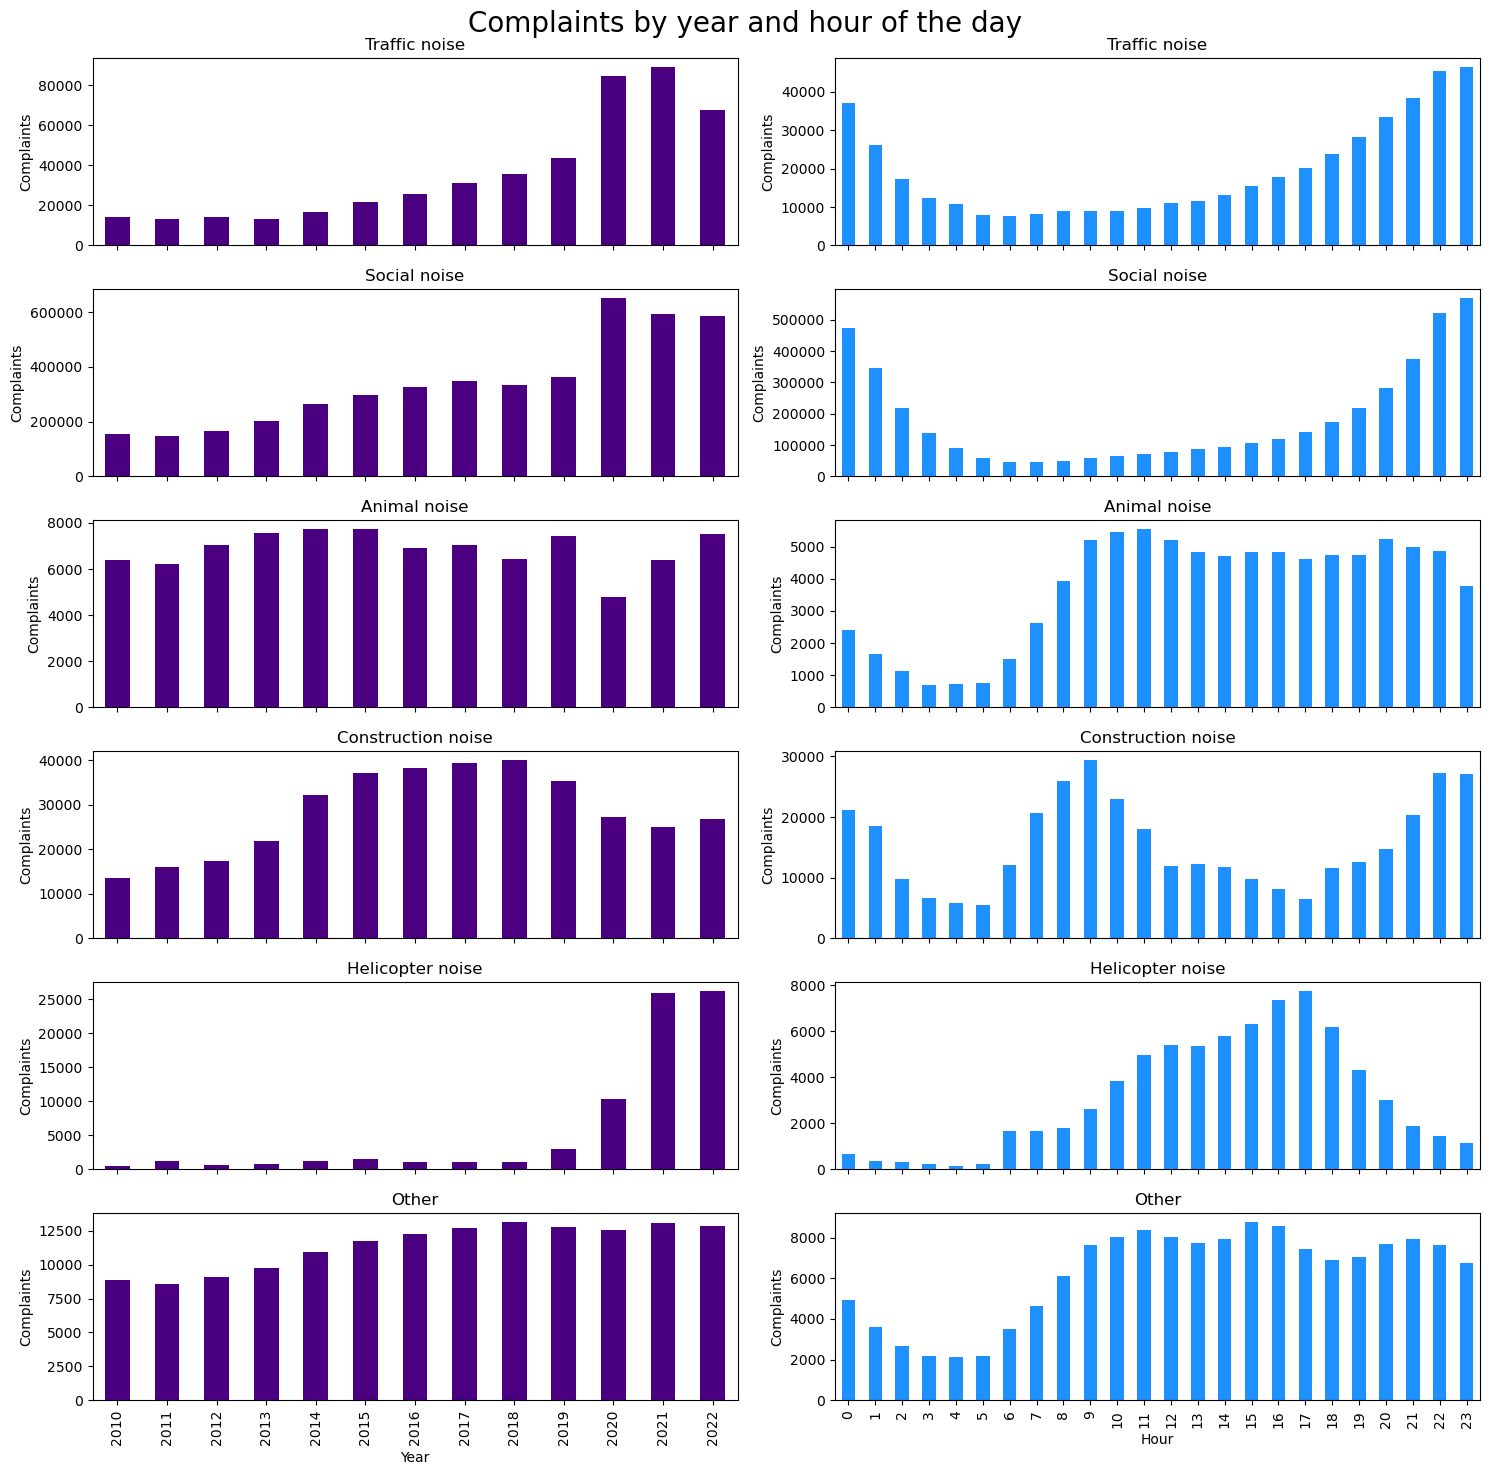

In [11]:
yearly_agg = data.groupby(['Category','Year'])['Unique Key'].nunique().reset_index(name='count')
hourly_agg = data.groupby(['Category','Hour'])['Unique Key'].nunique().reset_index(name='count')

#figure parameters
rows = 6
cols = 2
i = 0
fig, axs = plt.subplots(rows, cols, figsize=(15, 15))
fig.suptitle('Complaints by year and hour of the day', fontsize=20)

#plotting
for row in range(rows):   
    col = 0    
    yearly_agg[yearly_agg['Category'] == category_list[i]].sort_values(by='Year').plot.bar(ax=axs[row,col],
                                                                                           x = 'Year', 
                                                                                           y = 'count',
                                                                                           xlabel = 'Year',
                                                                                           ylabel = 'Complaints',
                                                                                           color = 'indigo',
                                                                                           sharex = True,
                                                                                           legend=None
                                                                                           )
    axs[row,col].set_title(category_list[i])
    col+=1
    
    hourly_agg[hourly_agg['Category'] == category_list[i]].sort_values(by='Hour').plot.bar(ax=axs[row,col],
                                                                                           x = 'Hour', 
                                                                                           y = 'count',
                                                                                           xlabel = 'Hour',
                                                                                           ylabel = 'Complaints',
                                                                                           color = 'dodgerblue',
                                                                                           sharex = True,
                                                                                           legend=None
                                                                                           )
    axs[row,col].set_title(category_list[i])
    i+=1
        
fig.tight_layout()

*caption: Panel showing histograms of number registered complaints for all 6 noise complaint groups both by year and hour of the day*

### Comment:

Most of the analyzed groups have different yearly and hourly patterns but there are similar patterns among some of them.

*Traffic* and *Social* noise groups are the most similar to each other. Complaints in those groups increased steadily until 2019 and spiked significantly in the last 3 years. This has most certainly been caused by covid forcing people to stay at home. Being unable to leave their homes people most likely found noise produced by their neighbours and passing by trains annoying. In terms of hourly patterns, almost a U-shaped distribution is observed. Starting at the lowest level in the early hours number of complaints grows reaching peaks during the night. New Yorkers might be used to this type of noise during the daytime as they are occupied with everyday tasks and most likely produce that noise themselves. It changes in the night when most of them try to relax and get some sleep. All of a sudden buzzing nightlife of their neighbours and loud vehicles becomes annoying.

*Animal* noise has mostly been stable during the analyzed period. There is only one visible drop in 2020 which again can probably be attributed to covid. As a lot of pet owners stayed at home their pets didn't miss their favourite human beings anymore which helped keep them quiet. As for the hourly pattern, during the day number of complaints is mostly stable and definitely higher than during the night which makes sense because pets just like humans value a good night's sleep. Very similar patterns can be observed in *Other* complaint group. It's hard to come up with a single explanation in that case tough because this group involves noise pollution of different characteristics but it follows the pattern of increased number of complaints at night and constant growth throughout the years.

*Construction* noise pollution is the only group that registered drops in recent years. It kept growing up until around 2019 and decreased ever since. Covid could be a significant factor here as it stopped a lot of ongoing and future construction problems. The lack of an increase in 2022 could also be influenced by the difficult economic situation. Hourly-wise two spikes can be observed one around 9 AM and the other around 23 PM. Although this noise is produced throughout the whole day they definitely become most frustrating when preventing people from falling asleep or waking them up early.

*Helicopter* noise pollution is the most surprising among the groups. Up until 2018, almost no such complaints have been registered and all of a sudden people started flooding the 311 line with them. Compared to the last two years the number of complaints increased over 10-fold and reached 25 000. As for the hourly pattern, during the night complaints are rather low and from 6 AM they start growing reaching peak at 5 PM. One of the helicopter's biggest advantages is avoiding traffic jams so its attractiveness grows in the rush hours. This type of noise will be further analyzed in a separate section.

All in all, the noise pollution level is very high and in most cases has grown over the last years. Definitely, it is a very big concern for the population of New York.

# Correlation

In [12]:
data_agg = data.groupby(['Year','Month','Category'])['Unique Key'].nunique().reset_index(name='count').sort_values(['Year','Month'])
pivot = data_agg.pivot_table('count', index=['Year','Month'], columns='Category').fillna(value=0).reset_index().drop('Helicopter noise', axis=1)

In [13]:
import itertools

#will help later with indexing subplots
rows = list(range(5))
cols = list(range(2))
combined = [rows,cols]
combs = []

for element in itertools.product(*combined):
    combs.append(element)

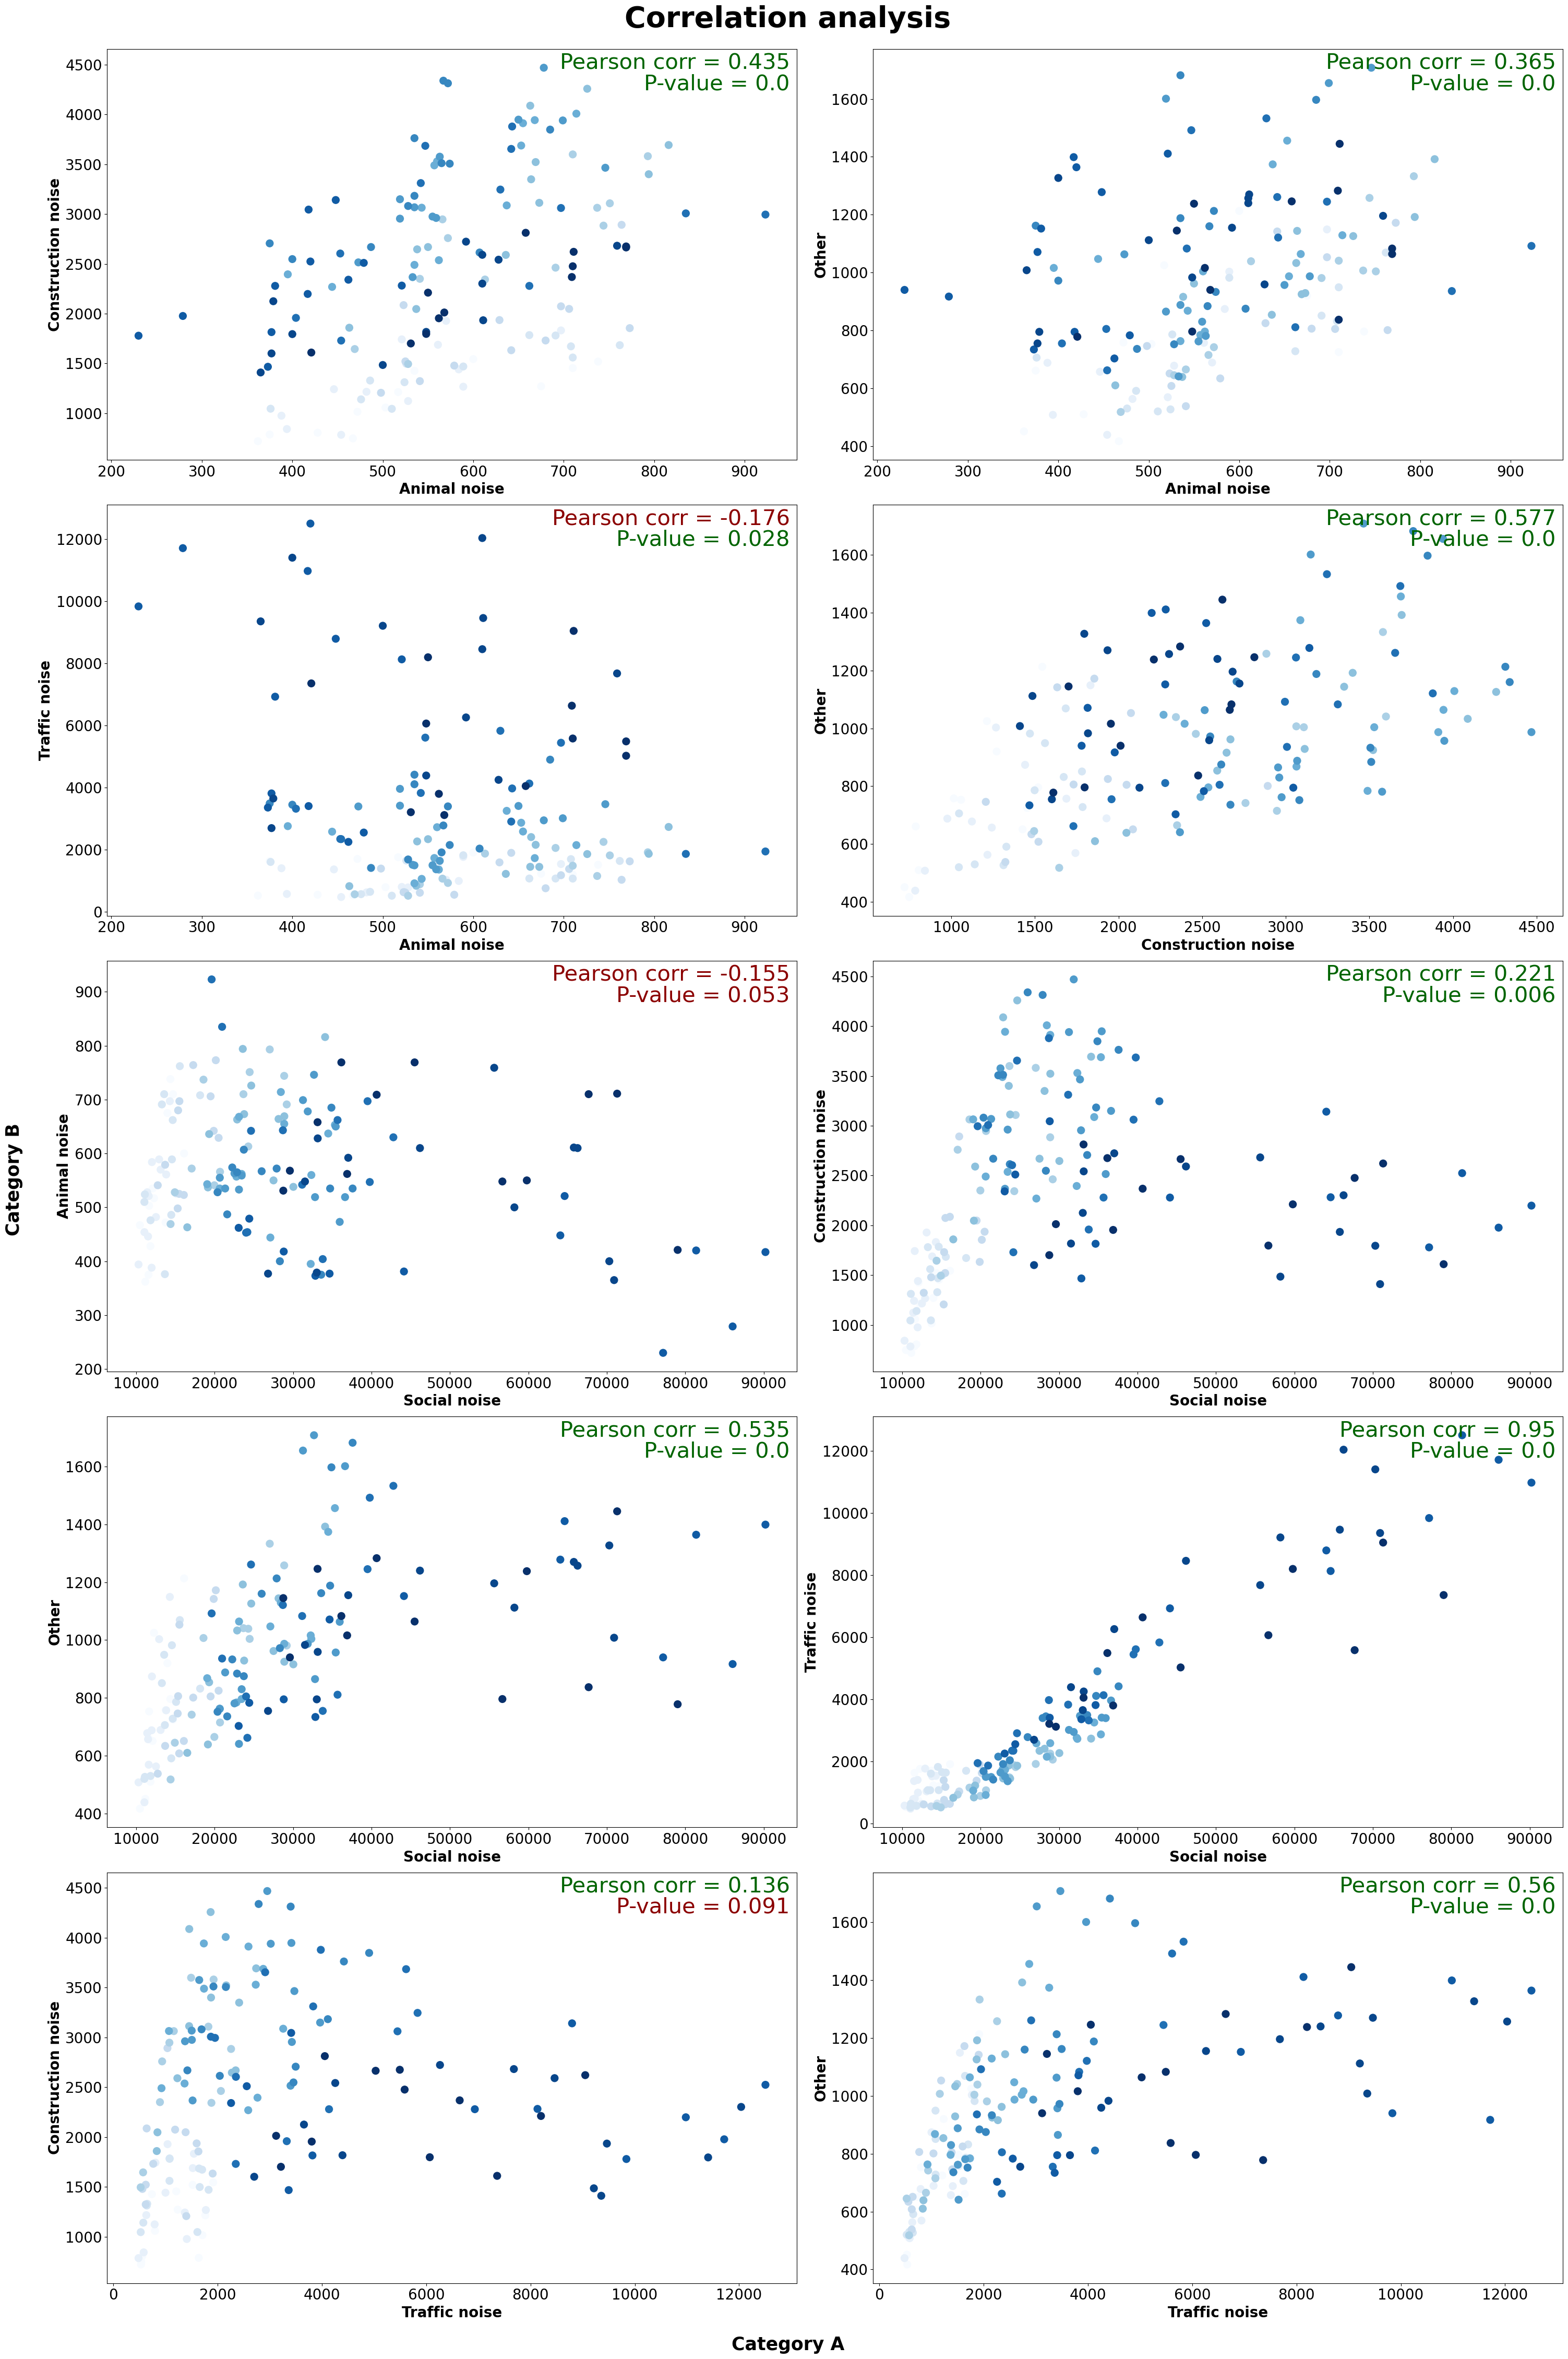

In [14]:
#certainly not the best approach as it requires data to be sorted but it works :)
fig,axes = plt.subplots(5, 2, figsize=(30,45))
i = 0

for first_cat, second_cat in sorted(list(itertools.combinations(data[data['Category'] != 'Helicopter noise']['Category'].unique(), 2))):
    
    r = combs[i][0]
    c = combs[i][1]
    
    x = pivot[str(first_cat)].values.reshape(-1, 1)
    y_true = pivot[str(second_cat)].values
    
    corr = stats.pearsonr(pivot[str(first_cat)].values, y_true)
    coef = corr[0]
    p_val = corr[1]
    
#     model = lm.LinearRegression()
#     model.fit(x,
#               y_true)
#     y_hat = model.predict(x)
#     residual = y_hat-y_true
#     r_sq = model.score(x, y_true)
    
    axes[r,c].scatter(x=x,
                      y=y_true,
                      c=pivot['Year'],
                      cmap='Blues',
                      s=100)

    axes[r,c].set_xlabel(first_cat, fontsize = 20, fontweight='bold')
    axes[r,c].set_ylabel(second_cat, fontsize = 20, fontweight='bold')
    
    p_val_col = 'darkred' if p_val >= 0.05 else 'darkgreen'
    coef_col = 'darkred' if coef <= 0 else 'darkgreen'
            
    axes[r,c].text(.99, .99, f'Pearson corr = {round(coef,3)}', ha='right', va='top', transform=axes[r,c].transAxes, fontsize=30, color = coef_col)
    axes[r,c].text(.99, .94, f'P-value = {round(p_val,3)}', ha='right', va='top', transform=axes[r,c].transAxes, fontsize=30, color = p_val_col)
    axes[r,c].tick_params(axis='both', which='major', labelsize=20)
    axes[r,c].tick_params(axis='both', which='minor', labelsize=20)
    
    i+=1

fig.suptitle('Correlation analysis', fontsize = 40, fontweight='bold', y = 1)
fig.supxlabel('Category A', fontsize = 25, fontweight='bold', y=0)
fig.supylabel('Category B', fontsize = 25, fontweight='bold', x=0)
fig.tight_layout()
fig.show()

fig.show()

*caption: Plots showing pairwise scatter plot comparison of noise complaints categories. Dots represent number of complaints in each month in the period. Observations have been color coded so that the darker the dots the more recent the observation. Pearsons correlation coefficients and coresponding p-values have also been added in the corners. Helicopter noise has been excluded from comparison due to very low measurements for most of the period*

### Comment:

Knowing the nature of the complaint group types let's now look at the relationship between them. Analyzing the number of complaints per month in the period pairwise it can be seen that most pairs have a positive correlation between each other. 

*Other* complaint group seems to be strongly positively correlated with all the other complaints. This might be because some of the unspecified noise sources could in fact be attributed to another group. It also matches the general impression of previous conclusions showing that noise pollution is mostly growing year by year.

Another pair worth taking a look at would be *Construction* and *Animal* noise. There is a clear pattern of positive correlation backed up by coefficient value and statistical significance. This might be due to construction works triggering noise coming from animals. Animals stressed by loud construction machinery often tend to become loud themselves. It only adds magnitude to the already frustrating noise coming from construction.

The highest relationship can be however observed between *Traffic* and *Social* noises. Here, the cigar-shaped pattern along with a very strong coefficient means that these two groups are very strongly interrelated. As discussed before there are many similarities between these groups. The more people commute the higher the chance we are going to hear them talk to each other. Also, any kind of popular social event like a concert or sports match means increased traffic in the area let alone parades which from a noise pollution point of view are trafficking social tumult.

Generally, in most cases, an increase in one type of noise pollution level comes along with an increase in some other group. When it rains it pours. It shows that the noise pollution problem in NY is a very complex issue but it could also potentially mean that tackling some of the issues could also reflect on the other.